In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.offline as py
import plotly.graph_objs as go
import math as m

import matplotlib.pyplot as plt

- This data was collected using GreenEnergy - Storm Glass API for latitude and longitude at: lat, lng = -6.168371, -35.096696

In [2]:
data = pd.read_csv("../input/tibau-wind-speed/data_tibau.csv", names=['time', 'velocity', 'direction'])
data

,time,velocity,direction
0,2020-03-12 12:00:00,6.78,90.02
1,2020-03-12 13:00:00,6.78,90.02
2,2020-03-12 14:00:00,6.78,90.02
3,2020-03-12 15:00:00,6.78,90.02
4,2020-03-12 16:00:00,6.78,90.02
...,...,...,...
10676,2021-05-31 08:00:00,3.24,90.08
10677,2021-05-31 09:00:00,3.28,90.08
10678,2021-05-31 10:00:00,3.48,90.08
10679,2021-05-31 11:00:00,3.68,90.07


In [3]:
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')

In [4]:
data['year'] = data['time'].dt.strftime("%Y") ## Extracting year to get mean velocity 

In [5]:
data

,time,velocity,direction,year
0,2020-03-12 12:00:00,6.78,90.02,2020
1,2020-03-12 13:00:00,6.78,90.02,2020
2,2020-03-12 14:00:00,6.78,90.02,2020
3,2020-03-12 15:00:00,6.78,90.02,2020
4,2020-03-12 16:00:00,6.78,90.02,2020
...,...,...,...,...
10676,2021-05-31 08:00:00,3.24,90.08,2021
10677,2021-05-31 09:00:00,3.28,90.08,2021
10678,2021-05-31 10:00:00,3.48,90.08,2021
10679,2021-05-31 11:00:00,3.68,90.07,2021


In [6]:
data[['velocity', 'year']].groupby(by='year').mean()

,velocity
year,
2020,4.959928
2021,4.912079


In [7]:
mean_velocity = data[['velocity', 'year']].groupby(by='year').mean()
mean_velocity

,velocity
year,
2020,4.959928
2021,4.912079


In [8]:
vel = list(data['velocity'])
scaled_velocity = list()

vel_min = data['velocity'].min()
vel_max = data['velocity'].max()

for i in vel:
    scaled_velocity.append((i - vel_min)/(vel_max - vel_min))

data['velocity'] = scaled_velocity ## Extracting max and min velocity, this way we preprocess the data for predictions. Later we'll reescale the predicted data

In [9]:
mean_velocity = 4.90

## This cell marks the start of the Blade Element Method, it's used to design a Wind turbine, for more information please check Aerodynamics of Wind Turbines

<img src="https://datasciencerecruit.files.wordpress.com/2021/06/image-1.png?w=839">

In [10]:
rm = 0.15 ## dead radius
ro = 1.18 ## Estimated air density
P = 830 ## desired potency
cp = 0.4 ## standard 0.35 - 0.45
visc_ar = 1.82*pow(10,-5) ## air viscosity
n = 0.90 ## gearbox efficiency
Pi = m.pi
mi = 7 ## tip-air speed
B = 3 ## blades
Cl = 1.70 ## S1223 Profile
Cd = 0.0163 ## drag
sections = 15 ## sections

In [11]:
R = m.sqrt(pow(rm,2)+P/(cp*n*0.5*ro*Pi*pow(mean_velocity,3))) #------------------------------ raio do rotor
w = mi*mean_velocity/R #--------------------------------------------------------------velocidade angular
R,w

(3.2550252283498056, 10.537552735770658)

In [12]:
radius = []
ratio = []
re = [] ##  Reynolds

for i in range(sections):
    r_section = R*rm + (i*((R - R*rm)/(sections-1))) ## Formula to avoid going to the tip
    ratio_section = r_section/R
    radius.append(r_section)
    ratio.append(ratio_section)
    reynolds = ro*mean_velocity*radius[i]/visc_ar
    re.append(reynolds) ## Calculate Reynolds, and the radius of the section

radius[sections-1] = radius[sections-2]+(radius[sections-1]-radius[sections-2])*0.1 
## raio igual da na posicao final da erro e quanto mais proximo da penultima, melhor o resultado

radius, ratio, re

([0.4882537842524708,
  0.685880315973709,
  0.8835068476949473,
  1.0811333794161855,
  1.2787599111374237,
  1.476386442858662,
  1.6740129745799,
  1.8716395063011382,
  2.069266038022376,
  2.2668925697436144,
  2.4645191014648526,
  2.662145633186091,
  2.859772164907329,
  3.0573986966285673,
  3.0771613498006913],
 [0.15,
  0.21071428571428572,
  0.27142857142857146,
  0.3321428571428572,
  0.3928571428571429,
  0.4535714285714286,
  0.5142857142857142,
  0.575,
  0.6357142857142857,
  0.6964285714285714,
  0.7571428571428571,
  0.8178571428571428,
  0.8785714285714286,
  0.9392857142857143,
  1.0],
 [155114.47145866955,
  217898.90038241676,
  280683.329306164,
  343467.7582299112,
  406252.1871536584,
  469036.61607740563,
  531821.0450011528,
  594605.4739248999,
  657389.9028486471,
  720174.3317723944,
  782958.7606961415,
  845743.1896198888,
  908527.618543636,
  971312.0474673832,
  1034096.4763911304])

## Chord - Schmitz

In [13]:
chord_schmitz = []

for i in range(sections):
    ang = mi*radius[i]
    atan = R / ( ang )
    sen_2 = (1/3) * m.atan( atan )

    section_chord = (16*Pi*radius[i]) / (B*Cl)  * pow(m.sin( sen_2 ),2)
    chord_schmitz.append(section_chord)

chord_schmitz

## Used to calculate the chord at each section

[0.30307571112944487,
 0.2631279256031714,
 0.2251315429476287,
 0.1941497634213551,
 0.16957797536352703,
 0.15000812307433714,
 0.13421561577303723,
 0.12127819707045899,
 0.11052408109082788,
 0.10146452093195613,
 0.09374034771789029,
 0.08708390674708433,
 0.08129273857269728,
 0.07621143396217778,
 0.07573744309195266]

## Schmitz

In [14]:
for j in range(sections):
    
    error_a = 1 ## Start relative error
    error_a_ = 1 
    a = 0.001 # Start a and a'
    a_ = 0.001
    i = 0 ## Count
    ac = 0.2 ## ac correction from Schmitz
    
    while (error_a > 0.001) and (error_a_ > 0.001):
 
        phi = m.atan(((1-a)/(1+a_))*(mean_velocity/(radius[j]*w))) ## Relative attack angle
            
        Cx = Cl*(m.sin(phi)) - Cd*(m.cos(phi)) ##  Tangential coef.
        Cy = Cl*(m.cos(phi)) + Cd*(m.sin(phi)) ## Normal coef.


        f = (B/2) * (R-radius[j])/(radius[j]*m.sin(phi))
        F = (2/Pi) * (m.acos(m.exp(-f)))
        sol = (chord_schmitz[j]*B)/(2*Pi*radius[j]) ## Terms to calculate the new a and a' from the Blade Element Method

        if a > 0.2: ## Correction for values of a greater than 0.2
            K = (4*F*pow(m.sin(phi),2))/(sol*Cy)
            a_new = 0.5 * (2 + K*(1 - 2*ac) - m.sqrt( pow((K*(1-2*ac)+2),2) + 4*(K*pow(ac,2) -1 ) ))
        else:
            a_new = 1 / (((4*F*pow(m.sin(phi),2))/(sol*Cy)) + 1)

        a_new_ = 1 / (( (4*F*m.sin(phi)*m.cos(phi)) / (sol*Cx)) - 1)

        error_a = m.fabs(((a_new - a)/a))
        error_a_ = m.fabs(((a_new_ - a_)/a_)) ## Calculate new error

        a = a_new
        a_ = a_new_ ## Substitute values
  
        i = i + 1

    print("Section ", j, "Chord: ", np.round(chord_schmitz[j],6), ", Phi:", np.round(m.degrees(phi),2))

Section  0 Chord:  0.303076 , Phi: 29.84
Section  1 Chord:  0.263128 , Phi: 23.55
Section  2 Chord:  0.225132 , Phi: 19.24
Section  3 Chord:  0.19415 , Phi: 16.24
Section  4 Chord:  0.169578 , Phi: 13.97
Section  5 Chord:  0.150008 , Phi: 12.24
Section  6 Chord:  0.134216 , Phi: 10.88
Section  7 Chord:  0.121278 , Phi: 9.78
Section  8 Chord:  0.110524 , Phi: 8.87
Section  9 Chord:  0.101465 , Phi: 8.07
Section  10 Chord:  0.09374 , Phi: 7.4
Section  11 Chord:  0.087084 , Phi: 6.78
Section  12 Chord:  0.081293 , Phi: 6.1
Section  13 Chord:  0.076211 , Phi: 5.13
Section  14 Chord:  0.075737 , Phi: 4.98


## This is the end of the Blade Element Method

In [15]:
data ## Checking the data

,time,velocity,direction,year
0,2020-03-12 12:00:00,0.704475,90.02,2020
1,2020-03-12 13:00:00,0.704475,90.02,2020
2,2020-03-12 14:00:00,0.704475,90.02,2020
3,2020-03-12 15:00:00,0.704475,90.02,2020
4,2020-03-12 16:00:00,0.704475,90.02,2020
...,...,...,...,...
10676,2021-05-31 08:00:00,0.336108,90.08,2021
10677,2021-05-31 09:00:00,0.340271,90.08,2021
10678,2021-05-31 10:00:00,0.361082,90.08,2021
10679,2021-05-31 11:00:00,0.381894,90.07,2021


In [16]:
## Index 9948 is the first day of May, so we'll separate the data before May, 2021 and After it.
## This way we'll use the data before this data to train and the May month to test.
## For the test, we'll start at 9941, as this will include the 7 previous data readings before the start of May

In [17]:
velocity_train = np.array(data['velocity'][0:9948])
velocity_train.shape

(9948,)

In [18]:
velocity_test = np.array(data['velocity'][9941:])
velocity_test.shape  ## Divided the data from before and after may, 2021

(740,)

In [19]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense  ## Importing relevant libraries for DL

In [20]:
def split_data(sequence, n_steps):
    X, Y = list(), list()
    for i in range(len(sequence)):
        initial = i
        end = i + n_steps
        if end > len(sequence)-1:
            break
        x_seq = sequence[initial:end]
        y_seq = sequence[end]
        X.append(x_seq)
        Y.append(y_seq)
    return np.array(X), np.array(Y)

## Creating a sequence of data, this will feed the neural network. n_steps is equal to the number of samples we want to
## use to predict a new value. In this example, we'll try to predict only one value based on 7 previous values. In a future work, we'll try more than one.

In [21]:
n_steps = 7
X1, Y1 = split_data(velocity_train, n_steps)

In [22]:
from sklearn.model_selection import train_test_split as tts
X_train, X_val, Y_train, Y_val = tts(X1, Y1, test_size=0.10) ## This will be our validation data, as we already have our test data

In [23]:
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features)) ## n_features is the number of values we'll predict
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features)) ## Reshape the data

In [24]:
## model = tf.keras.models.load_model('07_06_2020_20h55.h5') ## In case we need to load a previous saved model

In [25]:
model = keras.Sequential([keras.layers.Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)),
                          keras.layers.Dense(1)])  ## Creation of the LSTM layer and one single output

In [26]:
model.compile(optimizer='adam',
             loss='mse') ## Loss function

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(min_delta=0.00005, patience=50) ## This will make sure our model is improving, and if not, the fit will stop

In [28]:
history = model.fit(x=X_train,
                   epochs=200,
                    y=Y_train,
                    validation_data=(X_val,Y_val),
                    verbose=2,
                    callbacks=[early_stopping])

Epoch 1/200
280/280 - 5s - loss: 0.0215 - val_loss: 0.0027
Epoch 2/200
280/280 - 1s - loss: 0.0026 - val_loss: 0.0019
Epoch 3/200
280/280 - 1s - loss: 0.0018 - val_loss: 0.0013
Epoch 4/200
280/280 - 1s - loss: 0.0013 - val_loss: 0.0012
Epoch 5/200
280/280 - 1s - loss: 0.0011 - val_loss: 0.0011
Epoch 6/200
280/280 - 1s - loss: 9.7876e-04 - val_loss: 0.0013
Epoch 7/200
280/280 - 2s - loss: 9.6301e-04 - val_loss: 9.4041e-04
Epoch 8/200
280/280 - 1s - loss: 9.6836e-04 - val_loss: 8.4725e-04
Epoch 9/200
280/280 - 1s - loss: 8.7678e-04 - val_loss: 9.1840e-04
Epoch 10/200
280/280 - 1s - loss: 8.5988e-04 - val_loss: 8.1053e-04
Epoch 11/200
280/280 - 1s - loss: 8.9054e-04 - val_loss: 0.0010
Epoch 12/200
280/280 - 1s - loss: 7.9295e-04 - val_loss: 8.7184e-04
Epoch 13/200
280/280 - 1s - loss: 8.2619e-04 - val_loss: 9.4744e-04
Epoch 14/200
280/280 - 1s - loss: 8.5070e-04 - val_loss: 0.0015
Epoch 15/200
280/280 - 1s - loss: 8.1047e-04 - val_loss: 9.4759e-04
Epoch 16/200
280/280 - 1s - loss: 8.1784e

In [29]:
## Uncomment if want to save another model

## model.save("07_06_2020_21h15.h5") 

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1) ## Saving fit history for plotting

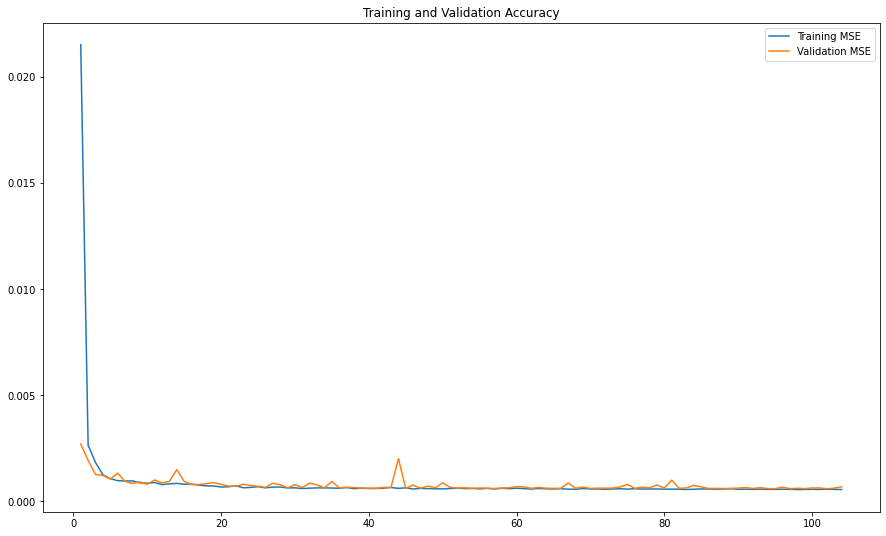

In [31]:
fig, ax = plt.subplots(figsize=(15,9))

ax.plot(epochs, loss, label='Training MSE')
ax.plot(epochs,val_loss, label='Validation MSE')
ax.set_title("Training and Validation Accuracy")
ax.legend()

 -------------------------------------------------------------------------------------------------------------- 

In [32]:
def predict_data(sequence, n_steps): 
    
    x_real, y_real = split_data(sequence, 7)
    
    predicted, real = list(), list()
    
    count = 0
    
    for i, j in zip(x_real,y_real):
        i = i.reshape(1,7,1)
        prediction = model.predict(i)[0][0] ## This way we extract the value
        print("Real: ", j, "Predicted: ", prediction)
        real.append(j)
        predicted.append(prediction)
        
    return predicted, real

## Creating a function to receive data, and then predict it. It does the same of the split data, it just adds the prediction part

In [33]:
predicted, real = predict_data(velocity_test, n_steps) ## Predict data in the test dat (May)

Real:  0.2851196670135276 Predicted:  0.2805006
Real:  0.22996878251821026 Predicted:  0.2608409
Real:  0.17585848074921956 Predicted:  0.18897328
Real:  0.12070759625390218 Predicted:  0.1372442
Real:  0.14672216441207075 Predicted:  0.090838164
Real:  0.1716961498439126 Predicted:  0.17189357
Real:  0.19771071800208118 Predicted:  0.20145065
Real:  0.20395421436004163 Predicted:  0.20861292
Real:  0.21123829344432887 Predicted:  0.21601155
Real:  0.21748178980228933 Predicted:  0.22501227
Real:  0.28824141519250784 Predicted:  0.2300567
Real:  0.3579604578563996 Predicted:  0.34566757
Real:  0.42872008324661814 Predicted:  0.4150001
Real:  0.4235171696149844 Predicted:  0.45505336
Real:  0.4193548387096775 Predicted:  0.4121405
Real:  0.41415192507804377 Predicted:  0.4028607
Real:  0.4068678459937565 Predicted:  0.42035967
Real:  0.3985431841831426 Predicted:  0.38640147
Real:  0.3912591050988554 Predicted:  0.37601465
Real:  0.41623309053069724 Predicted:  0.38171655
Real:  0.44224

In [34]:
re_vel = list(predicted)
re_vel_real = list(real)

rescaled_velocity = list()
rescaled_real_velocity = list()

for i,j in zip(re_vel, re_vel_real):
    rescaled_velocity.append(i * (vel_max - vel_min) + vel_min)
    rescaled_real_velocity.append(j * (vel_max - vel_min) + vel_min)
    
    ## Reescaling the data, based on our max and min velocity

In [35]:
May = pd.DataFrame({"time":np.array(data['time'][9948:]), "real":rescaled_real_velocity, "predictions":rescaled_velocity})
May

## Creating a May dataframe to compare results

,time,real,predictions
0,2021-05-01 00:00:00,2.75,2.705611
1,2021-05-01 01:00:00,2.22,2.516681
2,2021-05-01 02:00:00,1.70,1.826033
3,2021-05-01 03:00:00,1.17,1.328917
4,2021-05-01 04:00:00,1.42,0.882955
...,...,...,...
728,2021-05-31 08:00:00,3.24,3.202402
729,2021-05-31 09:00:00,3.28,3.281642
730,2021-05-31 10:00:00,3.48,3.262199
731,2021-05-31 11:00:00,3.68,3.614785


In [36]:
import plotly
import plotly.graph_objs as go
import plotly.offline as py

In [37]:
trace = [go.Scatter(x=May.time,
                     y=May.real,
                     name='Real'),
          
          go.Scatter(x=May.time,
                     y=May.predictions,
                     name='Predicted')]    
          
layout = go.Layout(title="Prediction x Real values of Wind Speed")

fig = go.Figure(data=trace, layout=layout)
          
py.iplot(fig)

In [38]:
power_predict = list()
power_real = list()

for i,j in zip(May['predictions'], May['real']):
    if i > 3:
        power_predict.append(0.20*0.5*ro*pow(i,3)*pow((R-rm),2)*Pi)  
        power_real.append(0.20*0.5*ro*pow(j,3)*pow((R-rm),2)*Pi)
        ## rm is the "dead radius" where the turbines pratically doesn't "generate" energy
        ## 0.20 takes into account the betz limit and efficiency for 3 blades and gearbox
    else:
        power_predict.append(0)
        power_real.append(0)

print("The total energy generated for this wind turbines is estimated as: ", np.sum(power_predict),
      "W. The real production would be: ", np.sum(power_real)," W")

The total energy generated for this wind turbines is estimated as:  145768.71580336386 W. The real production would be:  150537.99098558712  W


## Great results!

 ----------------------------------------------------------------------------